# Problem Statment
1. Bagaimana faktor-faktor seperti cuaca, tingkat lalu lintas, dan waktu dalam sehari mempengaruhi waktu pengiriman makanan?
2. Apakah ada korelasi antara jarak pengiriman dan waktu pengiriman makanan?
3. Bagaimana pengalaman kurir mempengaruhi waktu pengiriman?
4. Apakah jenis kendaraan yang digunakan berpengaruh terhadap waktu pengiriman?
5. Dapatkah kita memprediksi waktu pengiriman berdasarkan fitur-fitur yang tersedia?

# Import Libarary

In [5]:
# !pip install xgboost
# !pip install lightgbm
!pip install catboost

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [6]:
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import lightgbm as lgb
from scipy.stats import norm
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pickle



# Import Datasets

In [7]:
df = pd.read_csv('../Datasets/Food Delivery Time Prediction/Food_Delivery_Times.csv')

In [8]:
df.head()

,Order_ID,Distance_km,Weather,Traffic_Level,Time_of_Day,Vehicle_Type,Preparation_Time_min,Courier_Experience_yrs,Delivery_Time_min
0,522,7.93,Windy,Low,Afternoon,Scooter,12,1.0,43
1,738,16.42,Clear,Medium,Evening,Bike,20,2.0,84
2,741,9.52,Foggy,Low,Night,Scooter,28,1.0,59
3,661,7.44,Rainy,Medium,Afternoon,Scooter,5,1.0,37
4,412,19.03,Clear,Low,Morning,Bike,16,5.0,68


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Order_ID                1000 non-null   int64  
 1   Distance_km             1000 non-null   float64
 2   Weather                 970 non-null    object 
 3   Traffic_Level           970 non-null    object 
 4   Time_of_Day             970 non-null    object 
 5   Vehicle_Type            1000 non-null   object 
 6   Preparation_Time_min    1000 non-null   int64  
 7   Courier_Experience_yrs  970 non-null    float64
 8   Delivery_Time_min       1000 non-null   int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 70.4+ KB


In [10]:
df.describe()

,Order_ID,Distance_km,Preparation_Time_min,Courier_Experience_yrs,Delivery_Time_min
count,1000.000000,1000.000000,1000.000000,970.000000,1000.000000
mean,500.500000,10.059970,16.982000,4.579381,56.732000
std,288.819436,5.696656,7.204553,2.914394,22.070915
min,1.000000,0.590000,5.000000,0.000000,8.000000
25%,250.750000,5.105000,11.000000,2.000000,41.000000
50%,500.500000,10.190000,17.000000,5.000000,55.500000
75%,750.250000,15.017500,23.000000,7.000000,71.000000
max,1000.000000,19.990000,29.000000,9.000000,153.000000


# Data Preprocessing

## Data Cleaning

In [11]:
df.isnull().sum()

Order_ID                   0
Distance_km                0
Weather                   30
Traffic_Level             30
Time_of_Day               30
Vehicle_Type               0
Preparation_Time_min       0
Courier_Experience_yrs    30
Delivery_Time_min          0
dtype: int64

In [12]:
df['Weather'] = df['Weather'].fillna(df['Weather'].mode()[0])
df['Traffic_Level'] = df['Traffic_Level'].fillna(df['Traffic_Level'].mode()[0])
df['Time_of_Day'] = df['Time_of_Day'].fillna(df['Time_of_Day'].mode()[0])

df['Courier_Experience_yrs'] = df['Courier_Experience_yrs'].fillna(df['Courier_Experience_yrs'].median())

In [13]:
df.isnull().sum()

Order_ID                  0
Distance_km               0
Weather                   0
Traffic_Level             0
Time_of_Day               0
Vehicle_Type              0
Preparation_Time_min      0
Courier_Experience_yrs    0
Delivery_Time_min         0
dtype: int64

In [14]:
df.duplicated().sum()

0

## Data Transformation

In [15]:
df.head()

,Order_ID,Distance_km,Weather,Traffic_Level,Time_of_Day,Vehicle_Type,Preparation_Time_min,Courier_Experience_yrs,Delivery_Time_min
0,522,7.93,Windy,Low,Afternoon,Scooter,12,1.0,43
1,738,16.42,Clear,Medium,Evening,Bike,20,2.0,84
2,741,9.52,Foggy,Low,Night,Scooter,28,1.0,59
3,661,7.44,Rainy,Medium,Afternoon,Scooter,5,1.0,37
4,412,19.03,Clear,Low,Morning,Bike,16,5.0,68


In [16]:
# Display categorical features in a DataFrame
categorical_cols = df.select_dtypes(include=['object']).columns
categorical_df = pd.DataFrame({'Categorical Feature': categorical_cols})
categorical_df


,Categorical Feature
0,Weather
1,Traffic_Level
2,Time_of_Day
3,Vehicle_Type


In [17]:
# Displaying categorical data
categorical_columns = df.select_dtypes(include=['object']).columns
for col in categorical_columns:
    print(f"Column: {col}")
    print(df[col].value_counts())
    print("-" * 20)


Column: Weather
Weather
Clear    500
Rainy    204
Foggy    103
Snowy     97
Windy     96
Name: count, dtype: int64
--------------------
Column: Traffic_Level
Traffic_Level
Medium    420
Low       383
High      197
Name: count, dtype: int64
--------------------
Column: Time_of_Day
Time_of_Day
Morning      338
Evening      293
Afternoon    284
Night         85
Name: count, dtype: int64
--------------------
Column: Vehicle_Type
Vehicle_Type
Bike       503
Scooter    302
Car        195
Name: count, dtype: int64
--------------------


In [18]:
# Label encoding untuk data kategorikal
label_encoders = {}
categorical_cols = ['Weather', 'Traffic_Level', 'Time_of_Day','Vehicle_Type']
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

In [19]:
df.head()

,Order_ID,Distance_km,Weather,Traffic_Level,Time_of_Day,Vehicle_Type,Preparation_Time_min,Courier_Experience_yrs,Delivery_Time_min
0,522,7.93,4,1,0,2,12,1.0,43
1,738,16.42,0,2,1,0,20,2.0,84
2,741,9.52,1,1,3,2,28,1.0,59
3,661,7.44,2,2,0,2,5,1.0,37
4,412,19.03,0,1,2,0,16,5.0,68


# EDA

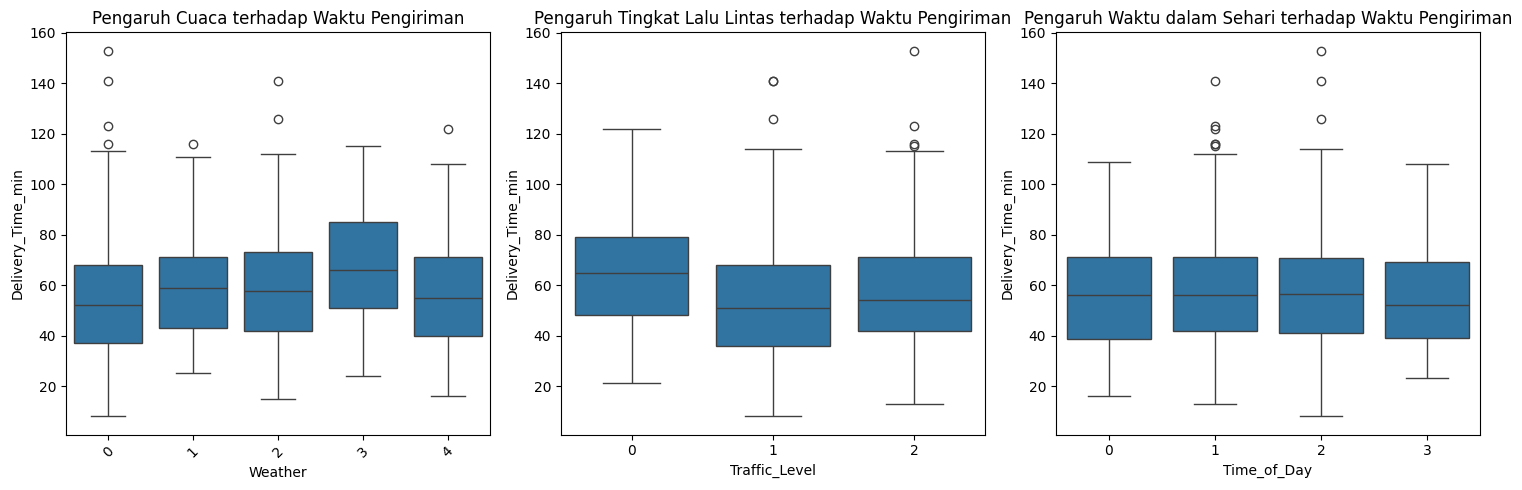

In [132]:
# 1. Pengaruh Cuaca, Lalu Lintas, dan Waktu dalam Sehari terhadap Waktu Pengiriman
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
sns.boxplot(x="Weather", y="Delivery_Time_min", data=df)
plt.xticks(rotation=45)
plt.title("Pengaruh Cuaca terhadap Waktu Pengiriman")

plt.subplot(1, 3, 2)
sns.boxplot(x="Traffic_Level", y="Delivery_Time_min", data=df)
plt.title("Pengaruh Tingkat Lalu Lintas terhadap Waktu Pengiriman")

plt.subplot(1, 3, 3)
sns.boxplot(x="Time_of_Day", y="Delivery_Time_min", data=df)
plt.title("Pengaruh Waktu dalam Sehari terhadap Waktu Pengiriman")

plt.tight_layout()
plt.show()


1. Pengaruh Cuaca terhadap Waktu Pengiriman

  * Waktu pengiriman tampaknya cukup bervariasi untuk semua kondisi cuaca.
  * Cuaca ekstrem (kode 3 dan 4) cenderung memiliki median waktu pengiriman yang sedikit lebih tinggi dibandingkan kondisi cuaca lainnya.
  * Rentang interkuartil (IQR) relatif mirip, tetapi ada beberapa outlier yang menunjukkan waktu pengiriman jauh lebih lama dalam kondisi tertentu.

2. Pengaruh Tingkat Lalu Lintas terhadap Waktu Pengiriman

  * Saat lalu lintas lebih tinggi (kode 0), waktu pengiriman cenderung lebih tinggi dibandingkan dengan lalu lintas lebih rendah.
  * Tingkat lalu lintas tampaknya memiliki pengaruh signifikan terhadap variasi waktu pengiriman, terlihat dari median yang meningkat dan beberapa outlier di kategori lalu lintas yang lebih tinggi.

3. Pengaruh Waktu dalam Sehari terhadap Waktu Pengiriman

  * Tidak terlihat perbedaan signifikan antar waktu dalam sehari.
  * Distribusi waktu pengiriman relatif seragam sepanjang hari, dengan median yang hampir sama di setiap kategori.
  * Ada beberapa outlier di setiap kategori, menunjukkan bahwa dalam kondisi tertentu, waktu pengiriman bisa lebih lama dari biasanya.

Kesimpulan

* Faktor cuaca dan lalu lintas tampaknya memiliki dampak lebih besar terhadap waktu pengiriman dibandingkan waktu dalam sehari.
* Cuaca ekstrem dan lalu lintas tinggi berkontribusi terhadap peningkatan waktu pengiriman.
* Perlu strategi mitigasi, seperti perencanaan rute yang lebih baik atau prediksi cuaca untuk menghindari keterlambatan pengiriman.

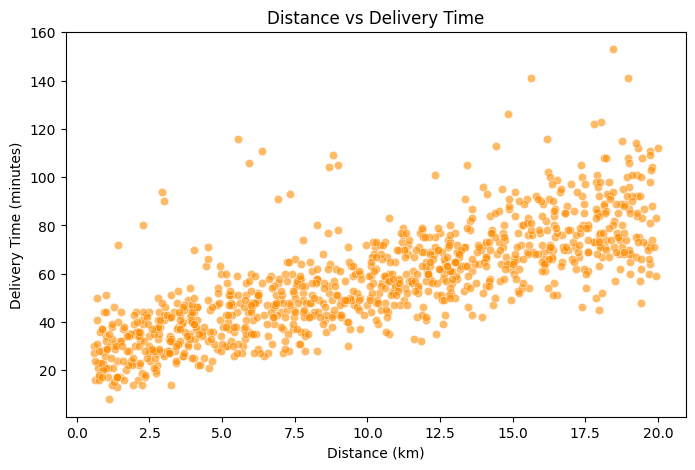

In [133]:
# Scatter plot: Jarak vs Waktu Pengiriman
plt.figure(figsize=(8, 5))
sns.scatterplot(x=df['Distance_km'], y=df['Delivery_Time_min'], alpha=0.6, color="darkorange")
plt.xlabel("Distance (km)")
plt.ylabel("Delivery Time (minutes)")
plt.title("Distance vs Delivery Time")
plt.show()


1. Hubungan Positif antara Jarak dan Waktu Pengiriman

  * Secara umum, semakin jauh jarak pengiriman (distance), semakin lama waktu yang dibutuhkan untuk pengiriman (delivery time).
  * Hal ini menunjukkan hubungan linier positif antara jarak dan waktu pengiriman.

2. Variasi dalam Waktu Pengiriman

  * Meskipun ada tren kenaikan, terdapat variasi signifikan dalam waktu pengiriman untuk jarak yang sama.
  * Contohnya, pada jarak sekitar 10 km, waktu pengiriman berkisar antara 40 hingga lebih dari 100 menit.
  * Variasi ini dapat disebabkan oleh faktor eksternal seperti kondisi lalu lintas, cuaca, atau efisiensi rute pengiriman.

3. Outlier dalam Waktu Pengiriman

  * Terdapat beberapa titik data yang menunjukkan waktu pengiriman yang jauh lebih lama dibandingkan dengan tren umum, terutama untuk jarak yang lebih pendek (<5km).
  * Hal ini bisa disebabkan oleh kendala operasional seperti kemacetan ekstrem, kesalahan dalam rute, atau masalah teknis pada kendaraan pengiriman.

Kesimpulan & Rekomendasi

* Hubungan positif antara jarak dan waktu pengiriman dapat digunakan untuk membangun model prediktif guna memperkirakan waktu pengiriman.
* Variasi yang cukup besar mengindikasikan perlunya faktor tambahan dalam analisis, seperti lalu lintas atau kondisi cuaca.
* Untuk mengatasi outlier, perusahaan dapat mengidentifikasi penyebab keterlambatan dan mengoptimalkan rute atau strategi pengiriman.

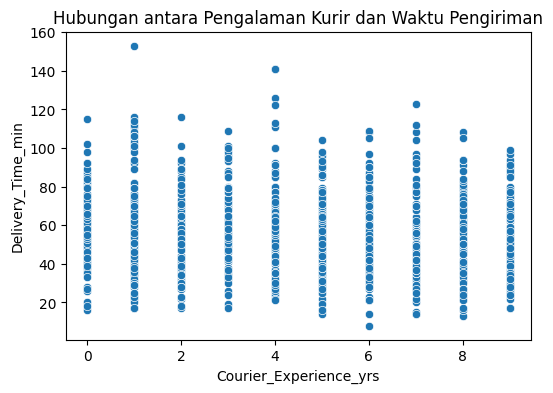

In [134]:
# 3. Pengaruh Pengalaman Kurir terhadap Waktu Pengiriman
plt.figure(figsize=(6, 4))
sns.scatterplot(x="Courier_Experience_yrs", y="Delivery_Time_min", data=df)
plt.title("Hubungan antara Pengalaman Kurir dan Waktu Pengiriman")
plt.show()

1. Tidak Ada Pola yang Jelas

  * Dari grafik, tidak terlihat adanya tren yang jelas antara pengalaman kurir (Courier_Experience_yrs) dan waktu pengiriman (Delivery_Time_min). Poin data tersebar secara merata di semua tingkat pengalaman.

2. Variasi Waktu Pengiriman dalam Semua Kategori

  * Terlepas dari pengalaman kurir, waktu pengiriman sangat bervariasi, dengan beberapa kurir memiliki waktu pengiriman cepat (di bawah 20 menit) dan beberapa lainnya memiliki waktu pengiriman yang lebih lama (di atas 100 menit).
Kurir dengan Pengalaman 0-1 Tahun Memiliki Rentang Waktu

3. Pengiriman Luas

  * Kurir yang baru memiliki pengalaman 0 tahun atau 1 tahun tampaknya memiliki variasi waktu pengiriman yang lebih luas, termasuk beberapa outlier dengan waktu pengiriman yang sangat lama.

4. Tidak Ada Indikasi Bahwa Pengalaman Mengurangi Waktu Pengiriman Secara Signifikan

  * Jika pengalaman kurir mempengaruhi waktu pengiriman, kita mungkin mengharapkan penurunan dalam waktu pengiriman seiring bertambahnya pengalaman. Namun, dari grafik ini, tidak ada indikasi yang jelas bahwa pengalaman yang lebih tinggi berkontribusi pada pengurangan waktu pengiriman.

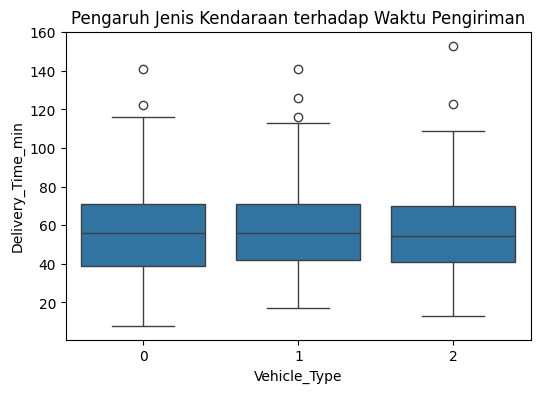

In [135]:
# 4. Pengaruh Jenis Kendaraan terhadap Waktu Pengiriman
plt.figure(figsize=(6, 4))
sns.boxplot(x="Vehicle_Type", y="Delivery_Time_min", data=df)
plt.title("Pengaruh Jenis Kendaraan terhadap Waktu Pengiriman")
plt.show()

1. Distribusi Waktu Pengiriman Relatif Mirip untuk Semua Jenis Kendaraan

  * Median waktu pengiriman untuk semua jenis kendaraan (0, 1, 2) berada di sekitar angka yang sama, sekitar 50-60 menit.
  * Hal ini menunjukkan bahwa jenis kendaraan tidak memiliki dampak signifikan terhadap waktu pengiriman secara keseluruhan.

2. Variasi Waktu Pengiriman yang Serupa

  * Rentang interkuartil (IQR) untuk ketiga jenis kendaraan terlihat mirip, menunjukkan bahwa mayoritas pengiriman memiliki waktu yang hampir sama terlepas dari kendaraan yang digunakan.
  * Rentang minimum hingga maksimum juga tidak menunjukkan perbedaan besar antar kategori kendaraan.

3. Outlier yang Muncul di Semua Jenis Kendaraan

  * Terdapat beberapa nilai outlier (waktu pengiriman ekstrem yang lebih tinggi, di atas 120 menit) pada ketiga jenis kendaraan.
  * Hal ini menunjukkan bahwa faktor lain, seperti kondisi lalu lintas atau jarak pengiriman, mungkin lebih berpengaruh terhadap waktu pengiriman dibandingkan jenis kendaraan.

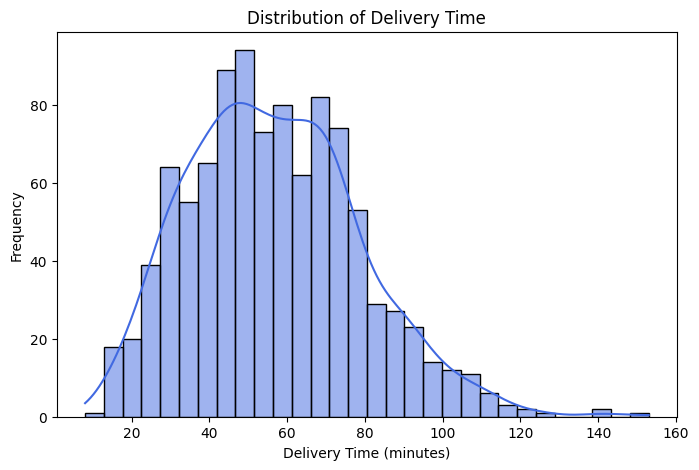

In [136]:
# Distribusi waktu pengiriman
plt.figure(figsize=(8, 5))
sns.histplot(df['Delivery_Time_min'], bins=30, kde=True, color="royalblue")
plt.xlabel("Delivery Time (minutes)")
plt.ylabel("Frequency")
plt.title("Distribution of Delivery Time")
plt.show()

1. Distribusi Positif Skewed

  * Histogram menunjukkan distribusi waktu pengiriman yang condong ke kanan (right-skewed). Artinya, sebagian besar pengiriman terjadi dalam waktu lebih singkat (sekitar 30-80 menit), tetapi ada beberapa kasus dengan waktu pengiriman yang jauh lebih lama (>100 menit).

2. Puncak Distribusi (Moda)

  * Puncak tertinggi dari histogram berada di sekitar 40-60 menit, yang menunjukkan bahwa sebagian besar pesanan tiba dalam rentang waktu ini.

3. Variasi Waktu Pengiriman

  * Meskipun sebagian besar pengiriman berlangsung dalam waktu 30-80 menit, ada beberapa kasus ekstrem yang memakan waktu lebih dari 100 menit, kemungkinan karena faktor seperti kemacetan, jarak pengiriman yang jauh, atau kendala operasional lainnya.

4. Potensi Optimalisasi

  * Jika perusahaan ingin meningkatkan kepuasan pelanggan, mereka bisa fokus pada faktor-faktor yang menyebabkan pengiriman di atas 80 menit dan mencari cara untuk menguranginya.

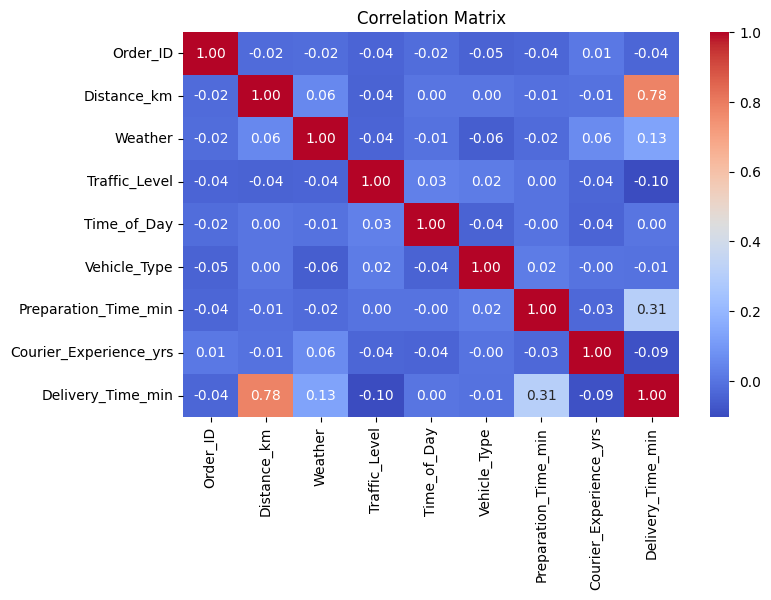

In [137]:
# Korelasi antar variabel
plt.figure(figsize=(8, 5))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

Insight dari Korelasi Data

1. Jarak (Distance_km) memiliki korelasi tinggi dengan Waktu Pengiriman (Delivery_Time_min)

  * Nilai korelasinya sekitar 0.78, yang menunjukkan hubungan positif yang kuat.
  * Semakin jauh jarak pengiriman, semakin lama waktu yang dibutuhkan untuk menyelesaikan pengiriman.
  * Hal ini masuk akal karena waktu pengiriman sangat dipengaruhi oleh jarak yang harus ditempuh.

2. Waktu Persiapan (Preparation_Time_min) memiliki korelasi sedang dengan Waktu Pengiriman (Delivery_Time_min)

  * Korelasi sekitar 0.31, menunjukkan bahwa semakin lama waktu persiapan, semakin lama total waktu pengiriman.
  * Namun, pengaruhnya tidak sekuat jarak.

3. Tingkat Lalu Lintas (Traffic_Level) tidak memiliki korelasi kuat dengan Waktu Pengiriman

  * Korelasi negatif lemah (-0.10) menunjukkan bahwa lalu lintas tidak terlalu berdampak signifikan pada waktu pengiriman dalam dataset ini.
  * Hal ini bisa terjadi karena pengiriman mungkin sudah dioptimalkan untuk menghindari kemacetan atau karena data lalu lintas kurang representatif.

4. Kondisi Cuaca (Weather) memiliki korelasi rendah dengan Waktu Pengiriman (Delivery_Time_min)

  * Nilai korelasi 0.13 menunjukkan bahwa cuaca tidak terlalu mempengaruhi waktu pengiriman dalam dataset ini.
  * Bisa jadi karena kendaraan yang digunakan sudah siap menghadapi kondisi cuaca buruk atau karena data cuaca tidak memiliki banyak variasi.

5. Pengalaman Kurir (Courier_Experience_yrs) memiliki korelasi negatif dengan Waktu Pengiriman

  * Korelasi -0.09, menunjukkan bahwa semakin berpengalaman kurir, waktu pengiriman cenderung lebih cepat, tetapi dampaknya tidak terlalu besar.

<ipython-input-138-dc5e3181caf9>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df['Weather'], y=df['Delivery_Time_min'], palette="coolwarm")


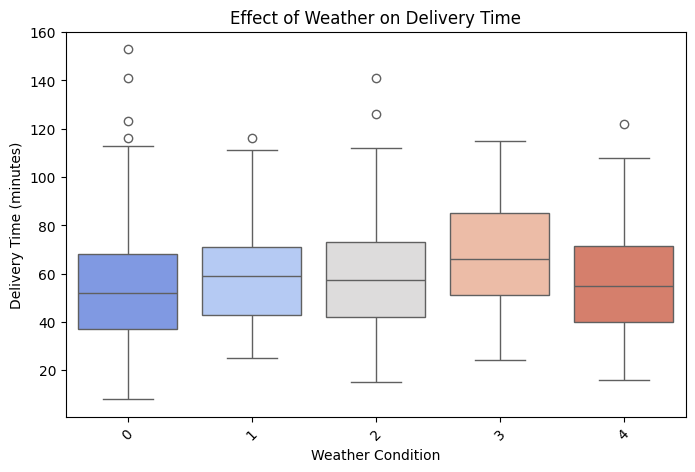

In [138]:
# Boxplot: Pengaruh Cuaca terhadap Waktu Pengiriman
plt.figure(figsize=(8, 5))
sns.boxplot(x=df['Weather'], y=df['Delivery_Time_min'], palette="coolwarm")
plt.xlabel("Weather Condition")
plt.ylabel("Delivery Time (minutes)")
plt.title("Effect of Weather on Delivery Time")
plt.xticks(rotation=45)
plt.show()

1. Cuaca Berpengaruh pada Waktu Pengiriman
  * Secara umum, semakin buruk kondisi cuaca, semakin tinggi median waktu pengiriman.
  * Cuaca ekstrem (kategori 3 dan 4) memiliki median waktu pengiriman yang lebih tinggi dibandingkan kategori cuaca lainnya.
  * Hal ini menunjukkan bahwa kondisi cuaca buruk dapat menyebabkan keterlambatan dalam pengiriman.

2. Variasi Waktu Pengiriman pada Setiap Kondisi Cuaca
  * Semua kategori cuaca memiliki rentang interkuartil (IQR) yang cukup lebar, menunjukkan adanya variasi waktu pengiriman.
  * Pada kategori cuaca lebih buruk (3 dan 4), distribusi waktu pengiriman lebih meluas, yang berarti ada kemungkinan peningkatan keterlambatan saat cuaca tidak bersahabat.
  * Banyak outlier pada setiap kondisi cuaca, terutama pada kategori cuaca lebih buruk, yang menunjukkan adanya pengiriman yang sangat lambat dibandingkan dengan rata-rata.
  
3. Cuaca Normal vs Cuaca Ekstrem
  * Pada kategori cuaca 0, 1, dan 2, median waktu pengiriman relatif lebih rendah dan lebih stabil.
  * Pada kategori cuaca 3 dan 4, tidak hanya median lebih tinggi, tetapi ada juga lebih banyak outlier yang mencerminkan lonjakan waktu pengiriman yang ekstrem.
  * Ini bisa disebabkan oleh hujan lebat, angin kencang, atau faktor lain yang menghambat perjalanan kurir.

Kesimpulan & Rekomendasi
  * Cuaca buruk memperlambat pengiriman: Strategi mitigasi seperti perencanaan rute alternatif atau prediksi cuaca dapat membantu mengurangi keterlambatan.
  * Monitoring lebih lanjut pada cuaca ekstrem: Perusahaan dapat meningkatkan kesiapan operasional, seperti menyesuaikan waktu estimasi pengiriman pada hari-hari dengan cuaca buruk.
  * Penanganan outlier: Investigasi lebih lanjut diperlukan untuk memahami alasan pengiriman yang jauh lebih lama dari biasanya.

# Pengembangan Model Machine Learning

## Feature Selection

In [20]:
# Memilih fitur dan target
features = ['Distance_km', 'Preparation_Time_min', 'Courier_Experience_yrs', 'Weather', 'Traffic_Level', 'Time_of_Day']
X = df[features]
y = df['Delivery_Time_min']

## Split Dataset

In [21]:
# Membagi data menjadi training dan testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

##  Modeling

### Linear Regression

In [22]:
# Membuat model regresi linear
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)

# Prediksi pada data uji
y_pred_rl = model_lr.predict(X_test)

# Evaluasi model
mae = mean_absolute_error(y_test, y_pred_rl)
mse = mean_squared_error(y_test, y_pred_rl)
rmse = mse ** 0.5
r2 = r2_score(y_test, y_pred_rl)

print(f"MAE: {mae}")
print(f"RMSE: {rmse}")
print(f"R-squared: {r2}")

MAE: 7.273346271096714
RMSE: 10.448888930077608
R-squared: 0.7564196579799813


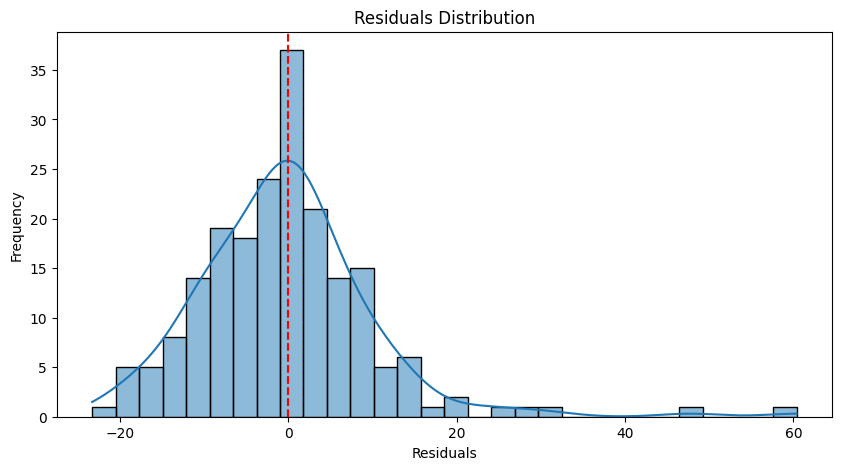

In [142]:
# Plot Residuals
plt.figure(figsize=(10, 5))
residuals = y_test - y_pred_rl
sns.histplot(residuals, bins=30, kde=True)
plt.axvline(x=0, color='red', linestyle='--')
plt.title("Residuals Distribution")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.show()



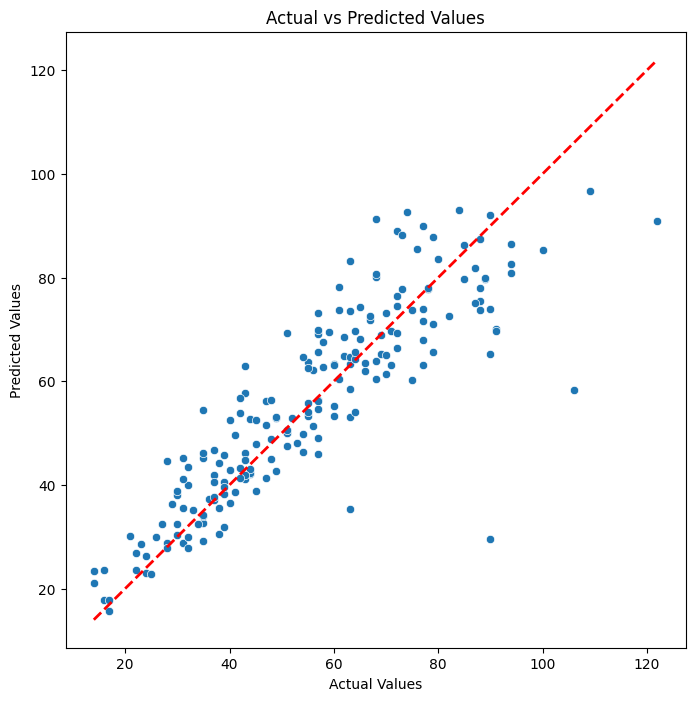

In [143]:
# Scatter Plot: Nilai Aktual vs Prediksi
plt.figure(figsize=(8, 8))
sns.scatterplot(x=y_test, y=y_pred_rl)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', lw=2)  # Garis referensi
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted Values")
plt.show()

### DecisionTree Regressor

In [144]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Membuat model Decision Tree
model_dt = DecisionTreeRegressor(random_state=42)
model_dt.fit(X_train, y_train)

# Prediksi pada data uji
y_pred_dt = model_dt.predict(X_test)

# Evaluasi model
mae_dt = mean_absolute_error(y_test, y_pred_dt)
mse_dt = mean_squared_error(y_test, y_pred_dt)
rmse_dt = mse_dt ** 0.5
r2_dt = r2_score(y_test, y_pred_dt)

print(f"MAE: {mae_dt}")
print(f"RMSE: {rmse_dt}")
print(f"R-squared: {r2_dt}")

MAE: 10.115
RMSE: 14.396701010995539
R-squared: 0.5375891868176832


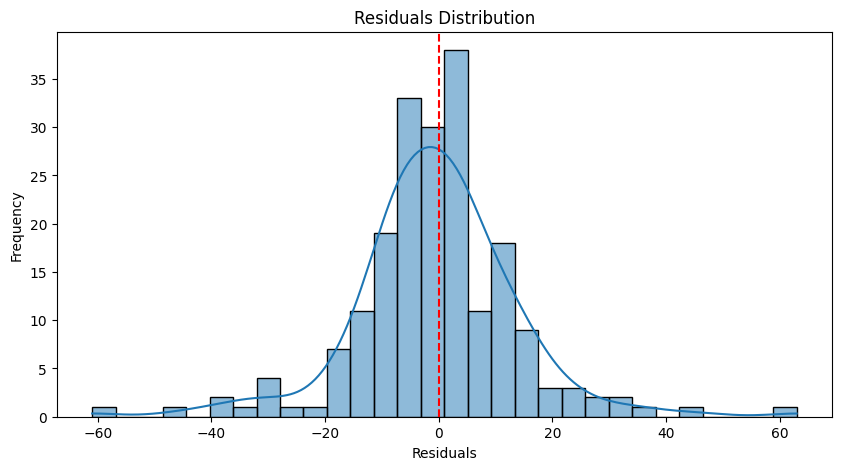

In [145]:
# Plot Residuals
plt.figure(figsize=(10, 5))
residuals = y_test - y_pred_dt
sns.histplot(residuals, bins=30, kde=True)
plt.axvline(x=0, color='red', linestyle='--')
plt.title("Residuals Distribution")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.show()



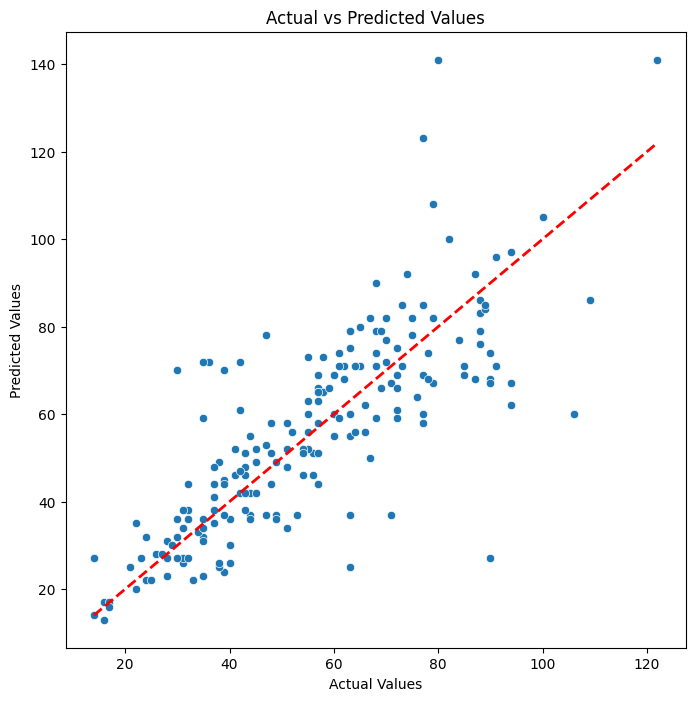

In [146]:
# Scatter Plot: Nilai Aktual vs Prediksi
plt.figure(figsize=(8, 8))
sns.scatterplot(x=y_test, y=y_pred_dt)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', lw=2)  # Garis referensi
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted Values")
plt.show()

### RandomForestRegressor

In [147]:
from sklearn.ensemble import RandomForestRegressor

# Membuat model Random Forest
model_rf = RandomForestRegressor(n_estimators=100, random_state=42)
model_rf.fit(X_train, y_train)

# Prediksi pada data uji
y_pred_rf = model_rf.predict(X_test)

# Evaluasi model
mae_rf = mean_absolute_error(y_test, y_pred_rf)
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = mse_rf ** 0.5
r2_rf = r2_score(y_test, y_pred_rf)

print(f"MAE: {mae_rf}")
print(f"RMSE: {rmse_rf}")
print(f"R-squared: {r2_rf}")

MAE: 7.02885
RMSE: 9.972609462923934
R-squared: 0.7781192452774623


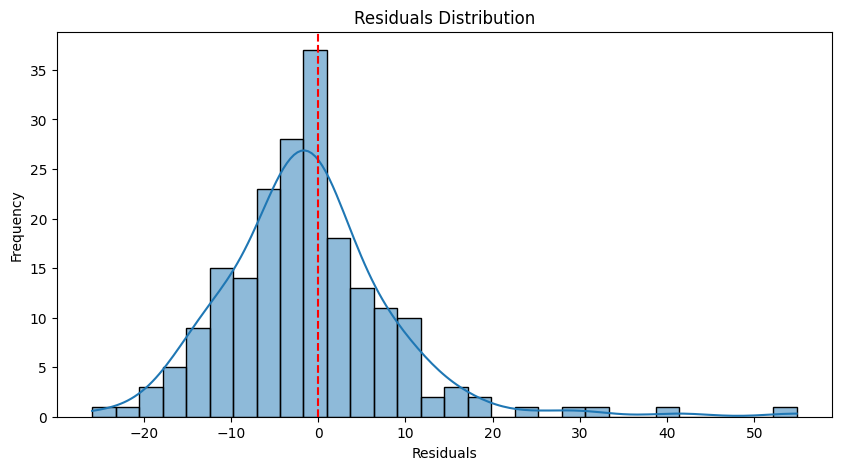

In [148]:
# Plot Residuals
plt.figure(figsize=(10, 5))
residuals = y_test - y_pred_rf
sns.histplot(residuals, bins=30, kde=True)
plt.axvline(x=0, color='red', linestyle='--')
plt.title("Residuals Distribution")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.show()



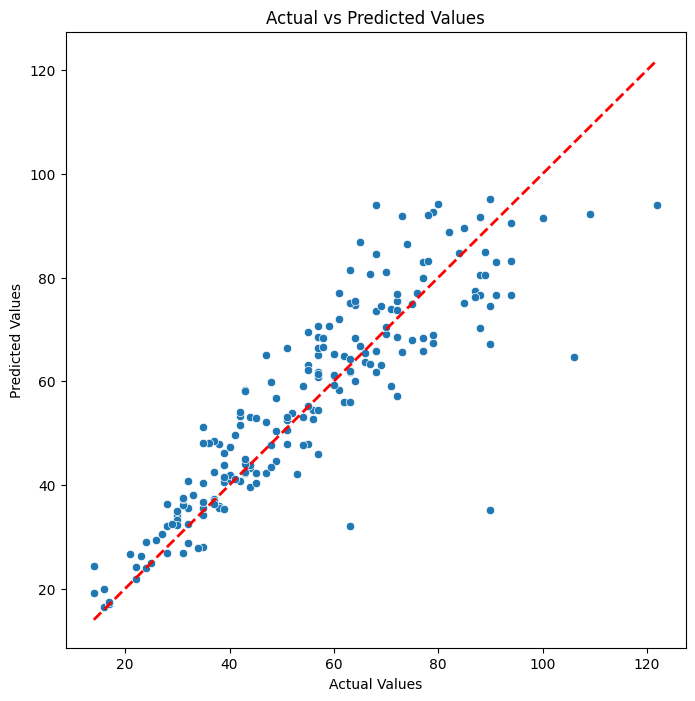

In [149]:
# Scatter Plot: Nilai Aktual vs Prediksi
plt.figure(figsize=(8, 8))
sns.scatterplot(x=y_test, y=y_pred_rf)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', lw=2)  # Garis referensi
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted Values")
plt.show()

### SVR

In [150]:
from sklearn.svm import SVR

# Membuat model SVR
model_svr = SVR(kernel='rbf')
model_svr.fit(X_train, y_train)

# Prediksi pada data uji
y_pred_svr = model_svr.predict(X_test)

# Evaluasi model
mae_svr = mean_absolute_error(y_test, y_pred_svr)
mse_svr = mean_squared_error(y_test, y_pred_svr)
rmse_svr = mse_svr ** 0.5
r2_svr = r2_score(y_test, y_pred_svr)

print(f"MAE: {mae_svr}")
print(f"RMSE: {rmse_svr}")
print(f"R-squared: {r2_svr}")


MAE: 7.721486560690733
RMSE: 11.017832530964665
R-squared: 0.7291715125347303


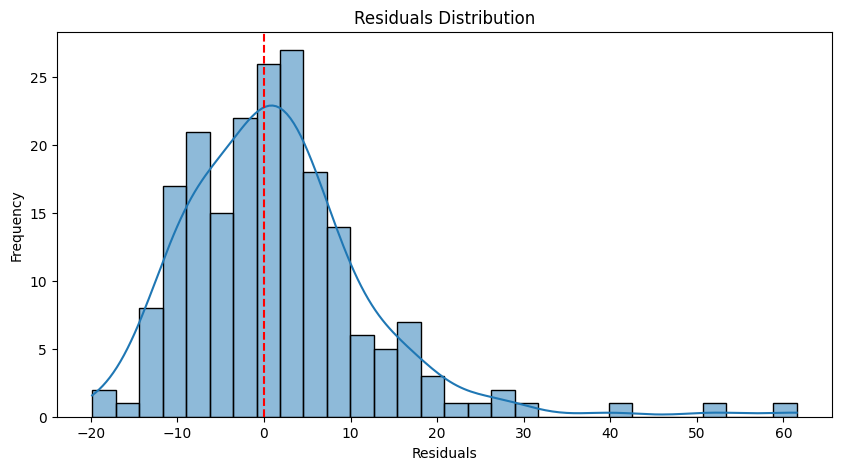

In [151]:
# Plot Residuals
plt.figure(figsize=(10, 5))
residuals = y_test - y_pred_svr
sns.histplot(residuals, bins=30, kde=True)
plt.axvline(x=0, color='red', linestyle='--')
plt.title("Residuals Distribution")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.show()



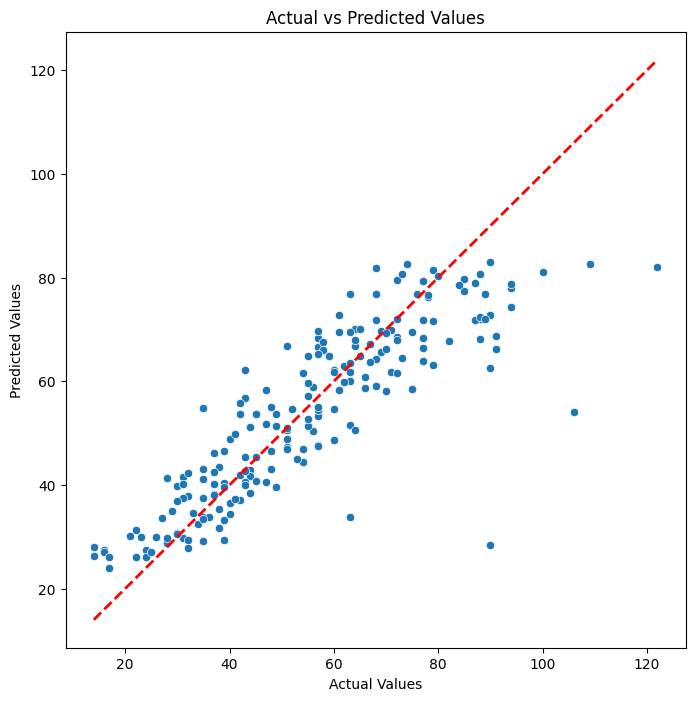

In [152]:
# Scatter Plot: Nilai Aktual vs Prediksi
plt.figure(figsize=(8, 8))
sns.scatterplot(x=y_test, y=y_pred_svr)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', lw=2)  # Garis referensi
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted Values")
plt.show()

### GradientBoostingRegressor

In [153]:
from sklearn.ensemble import GradientBoostingRegressor

# Membuat model Gradient Boosting
model_gb = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
model_gb.fit(X_train, y_train)

# Prediksi pada data uji
y_pred_gb = model_gb.predict(X_test)

# Evaluasi model
mae_gb = mean_absolute_error(y_test, y_pred_gb)
mse_gb = mean_squared_error(y_test, y_pred_gb)
rmse_gb = mse_gb ** 0.5
r2_gb = r2_score(y_test, y_pred_gb)

print(f"MAE: {mae_gb}")
print(f"RMSE: {rmse_gb}")
print(f"R-squared: {r2_gb}")

MAE: 6.591783547276575
RMSE: 9.402843434372885
R-squared: 0.8027484520508181


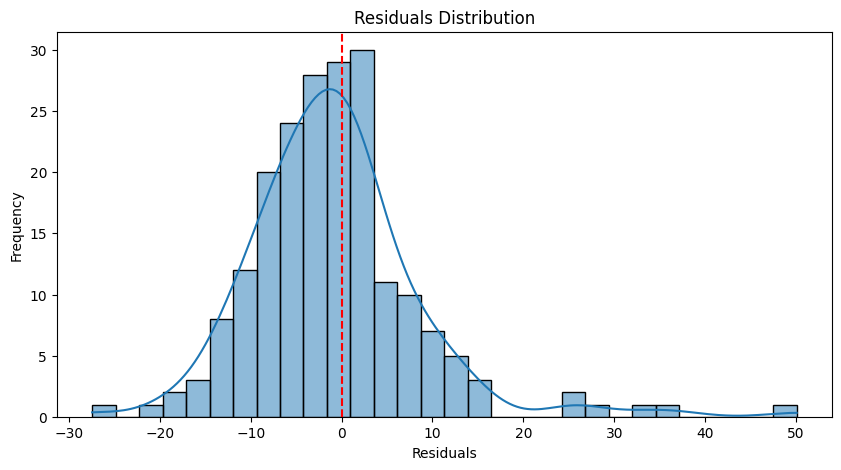

In [154]:
# Plot Residuals
plt.figure(figsize=(10, 5))
residuals = y_test - y_pred_gb
sns.histplot(residuals, bins=30, kde=True)
plt.axvline(x=0, color='red', linestyle='--')
plt.title("Residuals Distribution")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.show()



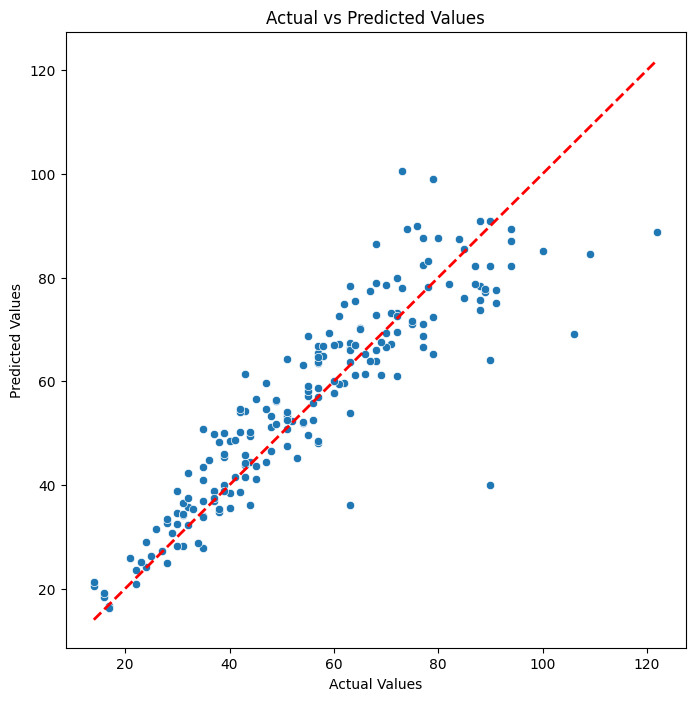

In [155]:
# Scatter Plot: Nilai Aktual vs Prediksi
plt.figure(figsize=(8, 8))
sns.scatterplot(x=y_test, y=y_pred_gb)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', lw=2)  # Garis referensi
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted Values")
plt.show()

### XGBoost

In [29]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Membuat model XGBoost
model_xgb = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
model_xgb.fit(X_train, y_train)

# Prediksi pada data uji
y_pred_xgb = model_xgb.predict(X_test)

# Evaluasi model
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
rmse_xgb = mse_xgb ** 0.5
r2_xgb = r2_score(y_test, y_pred_xgb)

print(f"MAE: {mae_xgb}")
print(f"RMSE: {rmse_xgb}")
print(f"R-squared: {r2_xgb}")


MAE: 7.224671545028687
RMSE: 10.12885394172201
R-squared: 0.7711122035980225


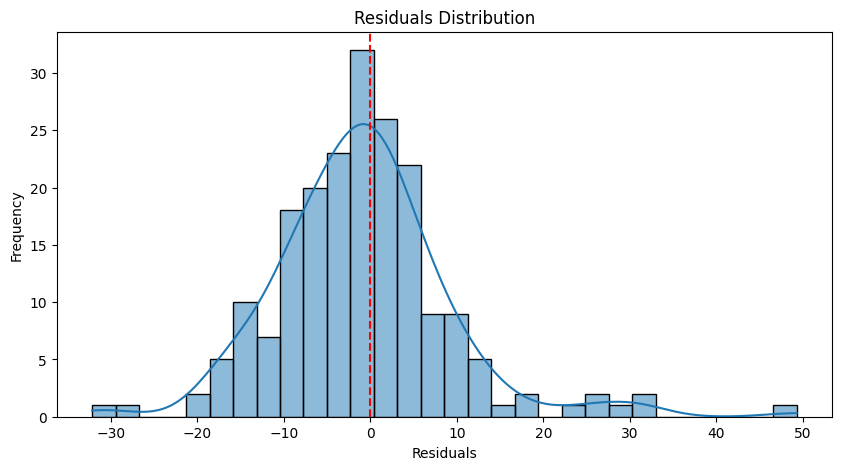

In [157]:
# Plot Residuals
plt.figure(figsize=(10, 5))
residuals = y_test - y_pred_xgb
sns.histplot(residuals, bins=30, kde=True)
plt.axvline(x=0, color='red', linestyle='--')
plt.title("Residuals Distribution")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.show()

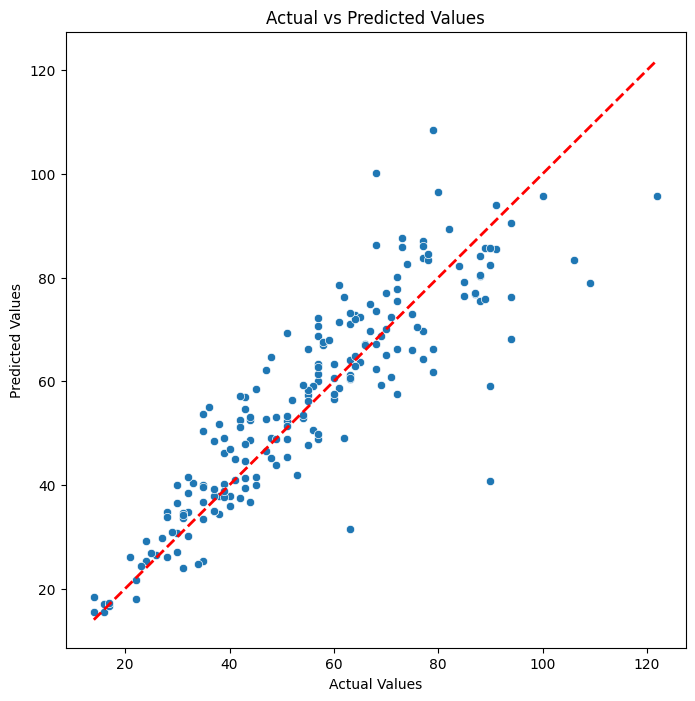

In [158]:
# Scatter Plot: Nilai Aktual vs Prediksi
plt.figure(figsize=(8, 8))
sns.scatterplot(x=y_test, y=y_pred_xgb)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', lw=2)  # Garis referensi
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted Values")
plt.show()

### LightGBM

In [159]:
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Membuat model LightGBM
model_lgbm = LGBMRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
model_lgbm.fit(X_train, y_train)

# Prediksi pada data uji
y_pred_lgbm = model_lgbm.predict(X_test)

# Evaluasi model
mae_lgbm = mean_absolute_error(y_test, y_pred_lgbm)
mse_lgbm = mean_squared_error(y_test, y_pred_lgbm)
rmse_lgbm = mse_lgbm ** 0.5
r2_lgbm = r2_score(y_test, y_pred_lgbm)

print(f"MAE: {mae_lgbm}")
print(f"RMSE: {rmse_lgbm}")
print(f"R-squared: {r2_lgbm}")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000212 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 302
[LightGBM] [Info] Number of data points in the train set: 800, number of used features: 6
[LightGBM] [Info] Start training from score 57.053750
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

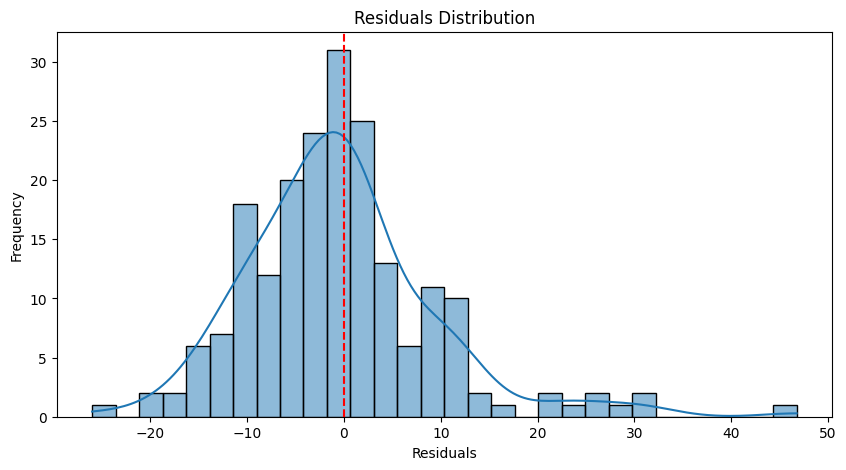

In [160]:
# Plot Residuals
plt.figure(figsize=(10, 5))
residuals = y_test - y_pred_lgbm
sns.histplot(residuals, bins=30, kde=True)
plt.axvline(x=0, color='red', linestyle='--')
plt.title("Residuals Distribution")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.show()

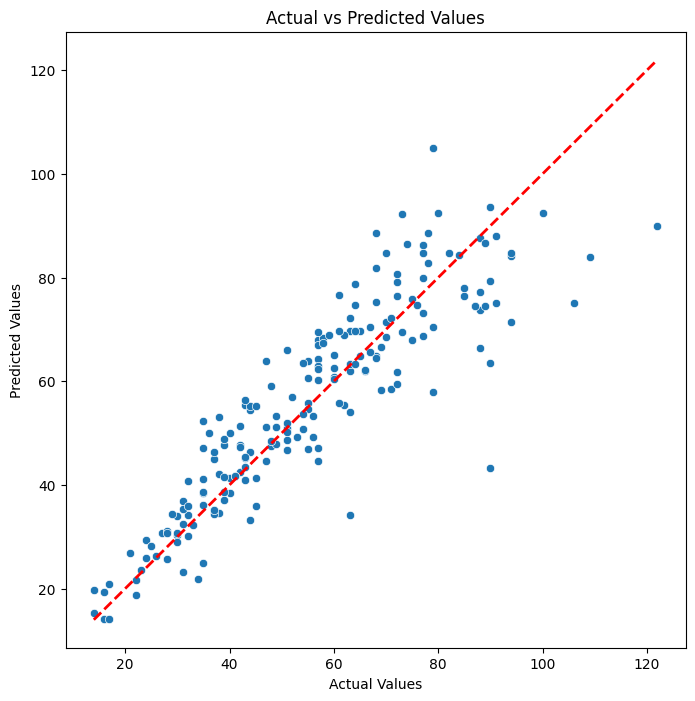

In [161]:
# Scatter Plot: Nilai Aktual vs Prediksi
plt.figure(figsize=(8, 8))
sns.scatterplot(x=y_test, y=y_pred_lgbm)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', lw=2)  # Garis referensi
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted Values")
plt.show()

## Optimasi Model

### Decision Tree Regressor

In [162]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor

# Definisi model
HT_model_dt = DecisionTreeRegressor(random_state=42)

# Grid parameter yang akan diuji
param_grid = {
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['squared_error', 'friedman_mse']
}

# Grid Search dengan cross-validation
grid_search = GridSearchCV(HT_model_dt, param_grid, cv=5, scoring='r2', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# Hasil terbaik
best_params = grid_search.best_params_
best_model_HT_DT = grid_search.best_estimator_

# Prediksi dengan model terbaik
y_pred_best_HT_DT = best_model_HT_DT.predict(X_test)

# Evaluasi model terbaik
mae_best = mean_absolute_error(y_test, y_pred_best_HT_DT)
mse_best = mean_squared_error(y_test, y_pred_best_HT_DT)
rmse_best = mse_best ** 0.5
r2_best = r2_score(y_test, y_pred_best_HT_DT)

print(f"Best Parameters: {best_params}")
print(f"MAE: {mae_best}")
print(f"RMSE: {rmse_best}")
print(f"R-squared: {r2_best}")


Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best Parameters: {'criterion': 'squared_error', 'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 10}
MAE: 8.835091511809333
RMSE: 12.042297323299705
R-squared: 0.6764654228524483


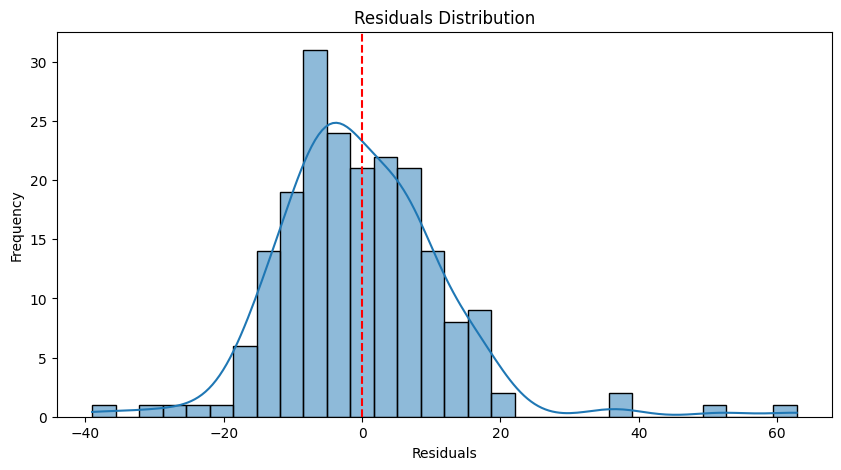

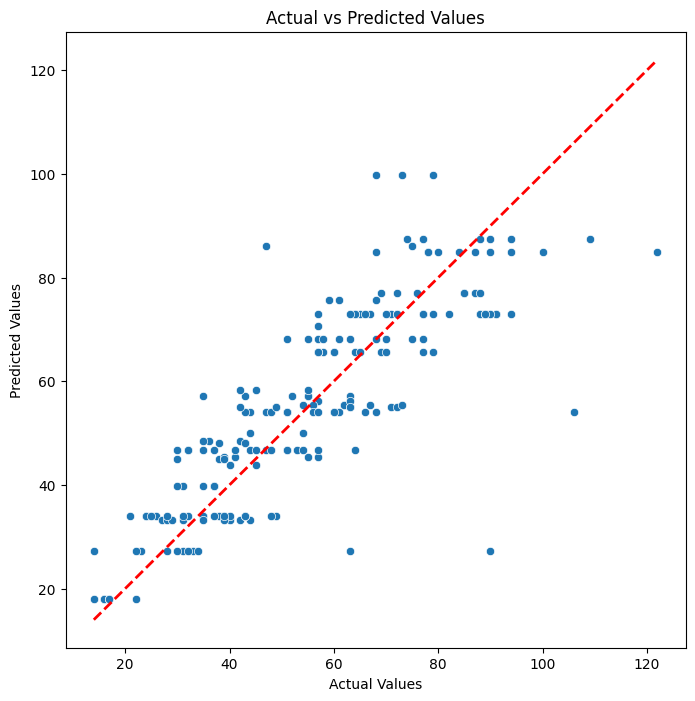

In [163]:
# Plot Residuals
plt.figure(figsize=(10, 5))
residuals = y_test - y_pred_best_HT_DT
sns.histplot(residuals, bins=30, kde=True)
plt.axvline(x=0, color='red', linestyle='--')
plt.title("Residuals Distribution")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.show()

# Scatter Plot: Nilai Aktual vs Prediksi
plt.figure(figsize=(8, 8))
sns.scatterplot(x=y_test, y=y_pred_best_HT_DT)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', lw=2)  # Garis referensi
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted Values")
plt.show()

### Random Forest Regressor

In [195]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# Definisi model
HT_model_rf = RandomForestRegressor(random_state=42)

# Grid parameter
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Grid Search
grid_search = GridSearchCV(HT_model_rf, param_grid, cv=5, scoring='r2', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# Model terbaik
best_params = grid_search.best_params_
best_model_HT_RF = grid_search.best_estimator_

# Evaluasi model
y_pred_best_HT_RF = best_model_HT_RF.predict(X_test)

# Evaluasi model terbaik
mae_best = mean_absolute_error(y_test, y_pred_best_HT_RF)
mse_best = mean_squared_error(y_test, y_pred_best_HT_RF)
rmse_best = mse_best ** 0.5
r2_best = r2_score(y_test, y_pred_best_HT_RF)

print(f"Best Parameters: {best_params}")
print(f"MAE: {mae_best}")
print(f"RMSE: {rmse_best}")
print(f"R-squared: {r2_best}")


Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best Parameters: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
MAE: 6.874977342135573
RMSE: 9.830194116701204
R-squared: 0.7844111984290393


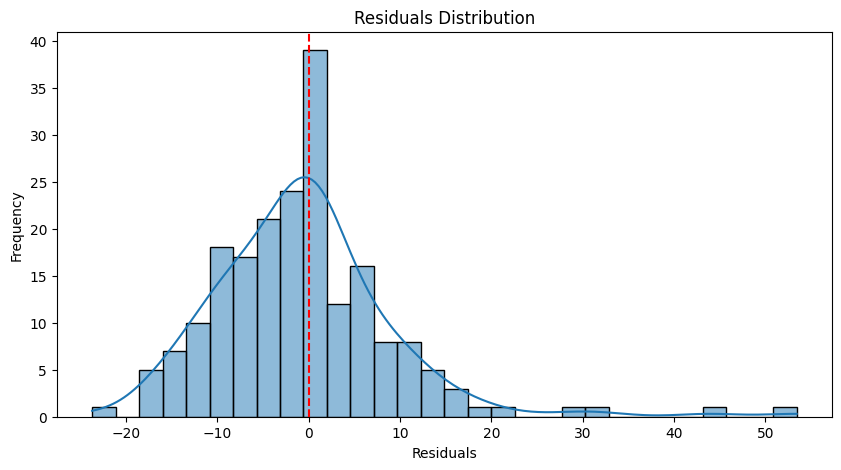

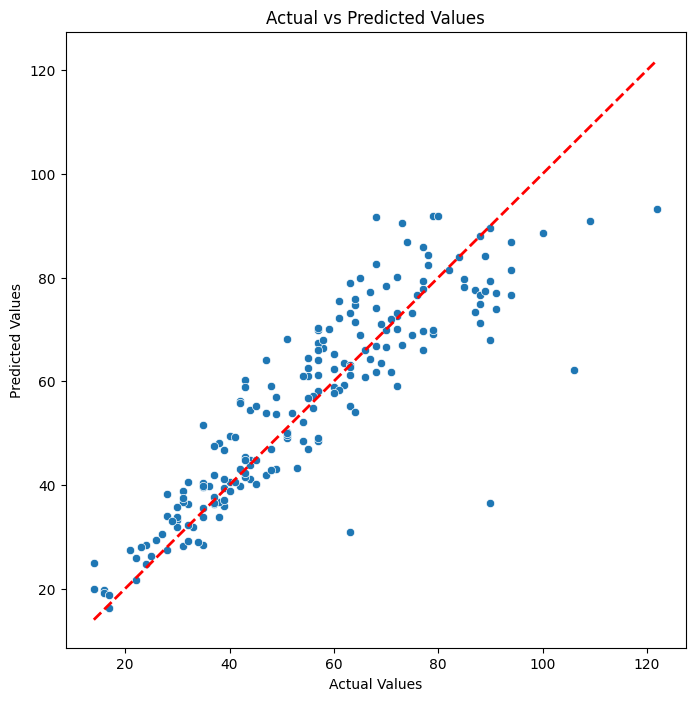

In [165]:
# Plot Residuals
plt.figure(figsize=(10, 5))
residuals = y_test - y_pred_best_HT_RF
sns.histplot(residuals, bins=30, kde=True)
plt.axvline(x=0, color='red', linestyle='--')
plt.title("Residuals Distribution")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.show()

# Scatter Plot: Nilai Aktual vs Prediksi
plt.figure(figsize=(8, 8))
sns.scatterplot(x=y_test, y=y_pred_best_HT_RF)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', lw=2)  # Garis referensi
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted Values")
plt.show()

### Support Vector Regressor (SVR)

In [196]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

# Definisi model
HT_model_svr = SVR()

# Grid parameter
param_grid = {
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'C': [0.1, 1, 10, 100],  # Regularization
    'epsilon': [0.01, 0.1, 0.5, 1],  # Toleransi margin
}

# Grid Search
grid_search = GridSearchCV(HT_model_svr, param_grid, cv=5, scoring='r2', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# Model terbaik
best_params = grid_search.best_params_
best_model_SVR = grid_search.best_estimator_

# Evaluasi model
y_pred_best_HT_SVR = best_model_SVR.predict(X_test)

# Evaluasi model terbaik
mae_best = mean_absolute_error(y_test, y_pred_best_HT_SVR)
mse_best = mean_squared_error(y_test, y_pred_best_HT_SVR)
rmse_best = mse_best ** 0.5
r2_best = r2_score(y_test, y_pred_best_HT_SVR)

print(f"Best Parameters: {best_params}")
print(f"MAE: {mae_best}")
print(f"RMSE: {rmse_best}")
print(f"R-squared: {r2_best}")


Fitting 5 folds for each of 64 candidates, totalling 320 fits
Best Parameters: {'C': 100, 'epsilon': 0.01, 'kernel': 'linear'}
MAE: 7.298624925777851
RMSE: 10.498627766540656
R-squared: 0.754095154624778


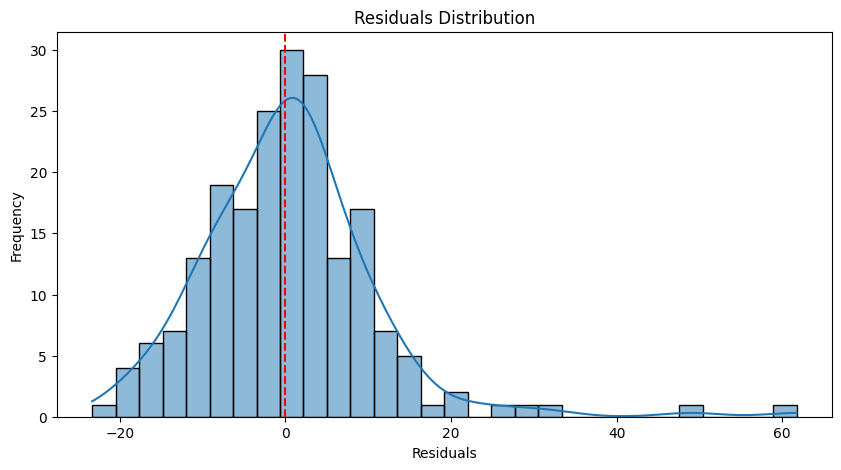

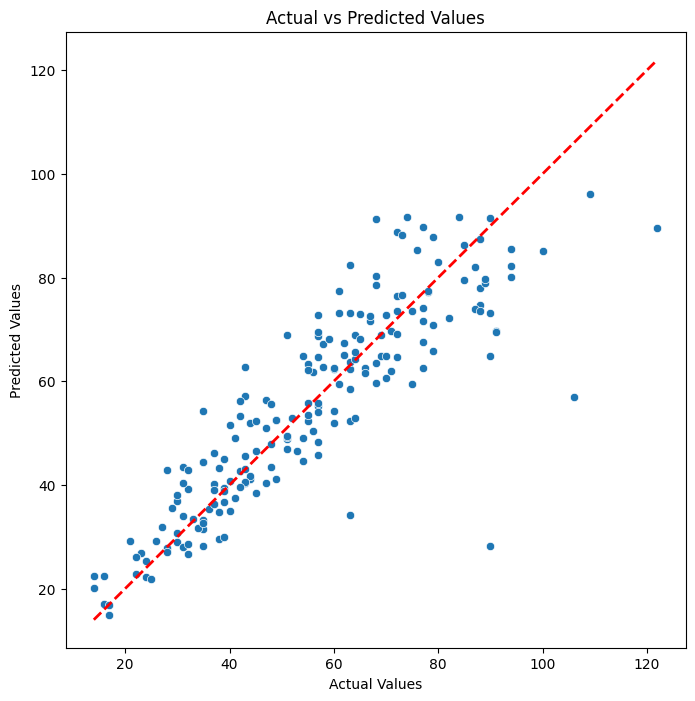

In [167]:
# Plot Residuals
plt.figure(figsize=(10, 5))
residuals = y_test - y_pred_best_HT_SVR
sns.histplot(residuals, bins=30, kde=True)
plt.axvline(x=0, color='red', linestyle='--')
plt.title("Residuals Distribution")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.show()

# Scatter Plot: Nilai Aktual vs Prediksi
plt.figure(figsize=(8, 8))
sns.scatterplot(x=y_test, y=y_pred_best_HT_SVR)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', lw=2)  # Garis referensi
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted Values")
plt.show()

### Gradient Boosting Regressor

In [197]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV

# Definisi model
HT_model_gb = GradientBoostingRegressor(random_state=42)

# Grid parameter
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Grid Search
grid_search = GridSearchCV(HT_model_gb, param_grid, cv=5, scoring='r2', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# Model terbaik
best_params = grid_search.best_params_
best_model_HT_GB = grid_search.best_estimator_

# Evaluasi model
y_pred_best_HT_GB = best_model_HT_GB.predict(X_test)

# Evaluasi model terbaik
mae_best = mean_absolute_error(y_test, y_pred_best_HT_GB)
mse_best = mean_squared_error(y_test, y_pred_best_HT_GB)
rmse_best = mse_best ** 0.5
r2_best = r2_score(y_test, y_pred_best_HT_GB)

print(f"Best Parameters: {best_params}")
print(f"MAE: {mae_best}")
print(f"RMSE: {rmse_best}")
print(f"R-squared: {r2_best}")


Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 50}
MAE: 6.609088478390499
RMSE: 9.42449577108235
R-squared: 0.8018389666548982


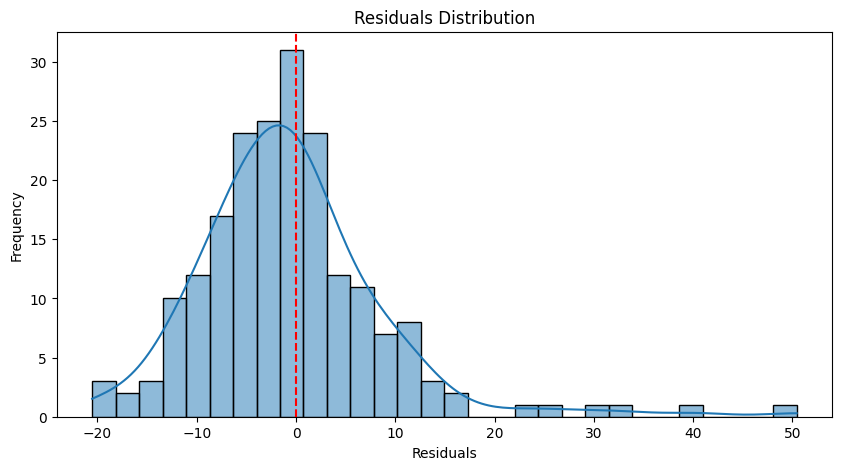

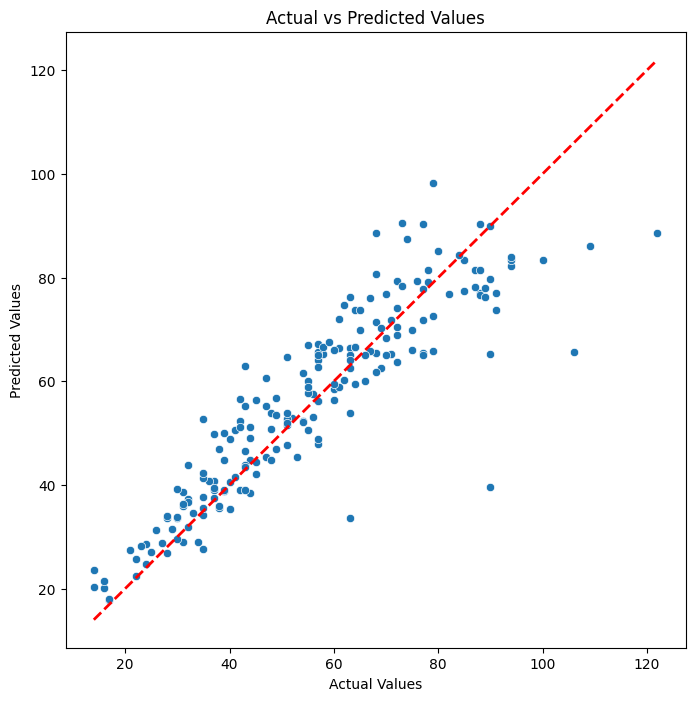

In [169]:
# Plot Residuals
plt.figure(figsize=(10, 5))
residuals = y_test - y_pred_best_HT_GB
sns.histplot(residuals, bins=30, kde=True)
plt.axvline(x=0, color='red', linestyle='--')
plt.title("Residuals Distribution")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.show()

# Scatter Plot: Nilai Aktual vs Prediksi
plt.figure(figsize=(8, 8))
sns.scatterplot(x=y_test, y=y_pred_best_HT_GB)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', lw=2)  # Garis referensi
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted Values")
plt.show()

### XGBoost Regressor

In [27]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV

# Definisi parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0]
}

# Inisialisasi model XGBoost
xgb = XGBRegressor(random_state=42)

# Grid Search dengan Cross Validation
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Model terbaik
best_model_XGB = grid_search.best_estimator_

# Prediksi pada data uji
y_pred_HT_xgb = best_model_XGB.predict(X_test)

# Evaluasi model
mae_xgb = mean_absolute_error(y_test, y_pred_HT_xgb)
mse_xgb = mean_squared_error(y_test, y_pred_HT_xgb)
rmse_xgb = mse_xgb ** 0.5
r2_xgb = r2_score(y_test, y_pred_HT_xgb)

print(f"Best Parameters: {grid_search.best_params_}")
print(f"MAE: {mae_xgb}")
print(f"RMSE: {rmse_xgb}")
print(f"R-squared: {r2_xgb}")

Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1.0}
MAE: 6.57020845413208
RMSE: 9.446924235598027
R-squared: 0.8008946776390076


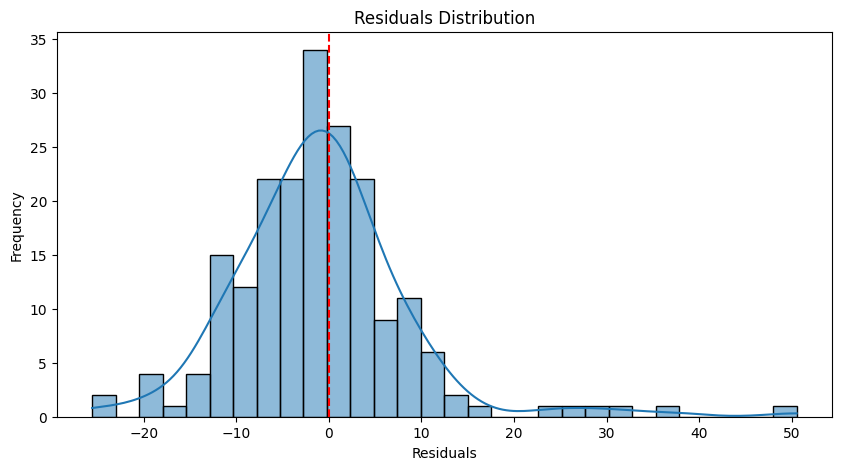

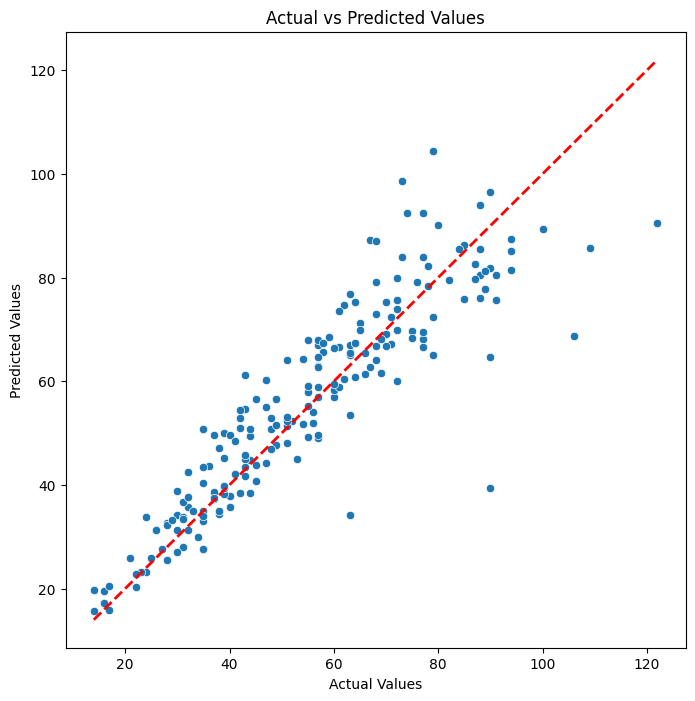

In [25]:
# Plot Residuals
plt.figure(figsize=(10, 5))
residuals = y_test - y_pred_HT_xgb
sns.histplot(residuals, bins=30, kde=True)
plt.axvline(x=0, color='red', linestyle='--')
plt.title("Residuals Distribution")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.show()

# Scatter Plot: Nilai Aktual vs Prediksi
plt.figure(figsize=(8, 8))
sns.scatterplot(x=y_test, y=y_pred_HT_xgb)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', lw=2)  # Garis referensi
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted Values")
plt.show()

### LightGBM Regressor

In [171]:
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV

# Definisi parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0]
}

# Inisialisasi model LightGBM
lgbm = LGBMRegressor(random_state=42)

# Grid Search dengan Cross Validation
grid_search = GridSearchCV(estimator=lgbm, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Model terbaik
best_model_HT_LGBM = grid_search.best_estimator_

# Prediksi pada data uji
y_pred_HT_lgbm = best_model_HT_LGBM.predict(X_test)

# Evaluasi model
mae_lgbm = mean_absolute_error(y_test, y_pred_HT_lgbm)
mse_lgbm = mean_squared_error(y_test, y_pred_HT_lgbm)
rmse_lgbm = mse_lgbm ** 0.5
r2_lgbm = r2_score(y_test, y_pred_HT_lgbm)

print(f"Best Parameters: {grid_search.best_params_}")
print(f"MAE: {mae_lgbm}")
print(f"RMSE: {rmse_lgbm}")
print(f"R-squared: {r2_lgbm}")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000148 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 302
[LightGBM] [Info] Number of data points in the train set: 800, number of used features: 6
[LightGBM] [Info] Start training from score 57.053750
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

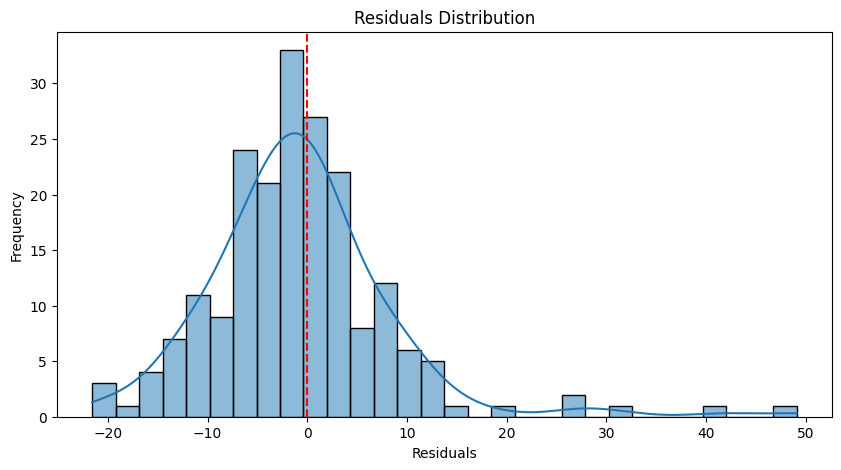

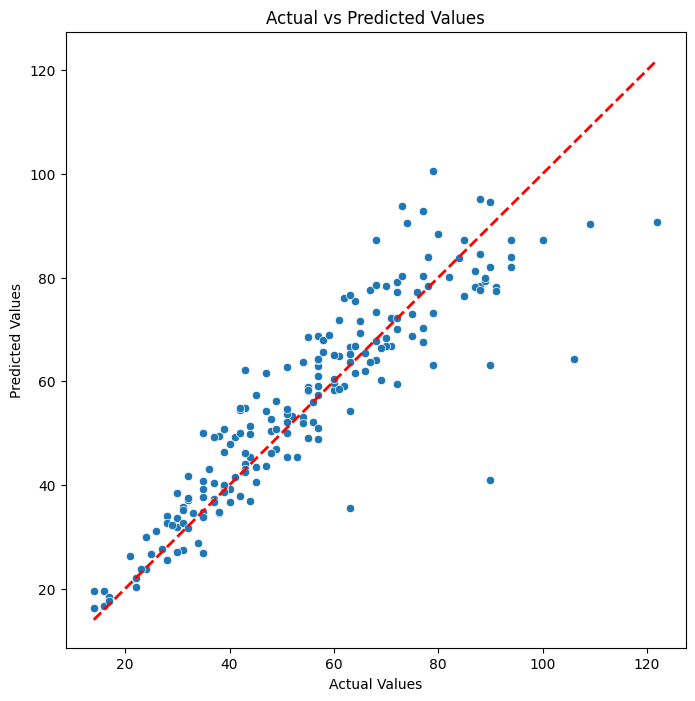

In [172]:
# Plot Residuals
plt.figure(figsize=(10, 5))
residuals = y_test - y_pred_HT_lgbm
sns.histplot(residuals, bins=30, kde=True)
plt.axvline(x=0, color='red', linestyle='--')
plt.title("Residuals Distribution")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.show()

# Scatter Plot: Nilai Aktual vs Prediksi
plt.figure(figsize=(8, 8))
sns.scatterplot(x=y_test, y=y_pred_HT_lgbm)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', lw=2)  # Garis referensi
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted Values")
plt.show()

# Save Model

## Linear Regression

In [173]:
model_path = 'LinearRegression_Model.pkl'
model = model_lr

with open(model_path, 'wb') as file:
    pickle.dump(model, file)

## Decision Tree Regressor

In [174]:
model_path = 'DecisionTreeRegressor_Model.pkl'
model = model_dt

with open(model_path, 'wb') as file:
    pickle.dump(model, file)

## Random Forest

In [175]:
model_path = 'RandomForest_Model.pkl'
model = model_rf

with open(model_path, 'wb') as file:
    pickle.dump(model, file)

## SVR

In [176]:
model_path = 'SVR_Model.pkl'
model = model_svr

with open(model_path, 'wb') as file:
    pickle.dump(model, file)

## GradientBoosting

In [177]:
model_path = 'GradientBoosting_Model.pkl'
model = model_gb

with open(model_path, 'wb') as file:
    pickle.dump(model, file)

## XGBoost

In [30]:
model_path = 'XGBoost_Model.pkl'
model = model_xgb

with open(model_path, 'wb') as file:
    pickle.dump(model, file)

## LightGBM

In [179]:
model_path = 'LightGBM_Model.pkl'
model = model_lgbm

with open(model_path, 'wb') as file:
    pickle.dump(model, file)

# Save Model Hyperparameter Tuning

## DecisionTree Regressor

In [180]:
model_path = 'HT_DecisionTreeRegressor_Model.pkl'
model = best_model_HT_DT

with open(model_path, 'wb') as file:
    pickle.dump(model, file)

## Random Forest Regressor

In [181]:
model_path = 'HT_RandomForest_Model.pkl'
model = best_model_HT_RF

with open(model_path, 'wb') as file:
    pickle.dump(model, file)

## SVR

In [182]:
model_path = 'HT_SVR_Model.pkl'
model = best_model_SVR

with open(model_path, 'wb') as file:
    pickle.dump(model, file)

## Gradient Boosting Regressor

In [183]:
model_path = 'HT_GradientBoosting_Model.pkl'
model = best_model_HT_GB

with open(model_path, 'wb') as file:
    pickle.dump(model, file)

## XGBoost

In [31]:
model_path = 'HT_XGBoost_Model.pkl'
model = best_model_XGB

with open(model_path, 'wb') as file:
    pickle.dump(model, file)

## LightGBM

In [184]:
model_path = 'HT_LightGBM_Model.pkl'
model = best_model_HT_LGBM

with open(model_path, 'wb') as file:
    pickle.dump(model, file)

# Testing

In [185]:
import numpy as np

# Ambil 5 sampel acak dari X_train sebagai data baru
data_baru = X_train.sample(5, random_state=42).copy()

# Ambil indeks yang sesuai di y_train untuk melihat nilai aktual
data_baru['Actual_Delivery_Time_min'] = y_train.loc[data_baru.index]

# Prediksi dengan model
prediksi_waktu = model_gb.predict(data_baru[features])

# Tambahkan hasil prediksi ke dataframe
data_baru['Predicted_Delivery_Time_min'] = prediksi_waktu

# Tampilkan hasil prediksi dan nilai aktual
data_baru


,Distance_km,Preparation_Time_min,Courier_Experience_yrs,Weather,Traffic_Level,Time_of_Day,Actual_Delivery_Time_min,Predicted_Delivery_Time_min
726,6.70,23,3.0,1,0,2,59,63.288881
138,15.81,25,1.0,0,1,2,92,79.876301
266,14.08,28,6.0,0,0,2,66,76.038306
765,17.99,11,2.0,1,1,2,84,77.157719
798,17.87,29,4.0,3,1,2,87,91.848386


In [186]:
import numpy as np

# Ambil 10 sampel acak dari X_train
data_baru = X_train.sample(10, random_state=42).copy()

# Ambil nilai aktual dari y_train
data_baru['Actual_Delivery_Time_min'] = y_train.loc[data_baru.index]

# Prediksi dengan model
prediksi_waktu = model_gb.predict(data_baru[features])

# Tambahkan hasil prediksi ke dataframe
data_baru['Predicted_Delivery_Time_min'] = prediksi_waktu

# Hitung selisih antara prediksi dan aktual (error absolut)
data_baru['Absolute_Error'] = abs(data_baru['Actual_Delivery_Time_min'] - data_baru['Predicted_Delivery_Time_min'])

# Filter data dengan error ≤ 5 menit (bisa disesuaikan)
data_benar = data_baru[data_baru['Absolute_Error'] <= 5]

# Tampilkan hasilnya
data_benar


,Distance_km,Preparation_Time_min,Courier_Experience_yrs,Weather,Traffic_Level,Time_of_Day,Actual_Delivery_Time_min,Predicted_Delivery_Time_min,Absolute_Error
726,6.70,23,3.0,1,0,2,59,63.288881,4.288881
798,17.87,29,4.0,3,1,2,87,91.848386,4.848386
512,1.29,7,7.0,2,1,1,15,14.397982,0.602018
579,7.69,16,3.0,2,0,2,58,58.281214,0.281214


In [187]:
import numpy as np

# Ambil 5 sampel acak dari X_train sebagai data baru
data_baru = X_train.sample(5, random_state=42).copy()

# Simpan nilai aslinya sebelum di-scaling (untuk referensi)
data_baru_original = data_baru.copy()

# Prediksi dengan model
prediksi_waktu = model_gb.predict(data_baru)

# Tambahkan hasil prediksi ke dataframe
data_baru_original['Predicted_Delivery_Time_min'] = np.round(prediksi_waktu).astype(int)

# Tampilkan hasil prediksi
data_baru_original.head()


,Distance_km,Preparation_Time_min,Courier_Experience_yrs,Weather,Traffic_Level,Time_of_Day,Predicted_Delivery_Time_min
726,6.70,23,3.0,1,0,2,63
138,15.81,25,1.0,0,1,2,80
266,14.08,28,6.0,0,0,2,76
765,17.99,11,2.0,1,1,2,77
798,17.87,29,4.0,3,1,2,92


In [188]:
import numpy as np

# Ambil 5 sampel acak dari X_train sebagai data baru
data_baru = X_test.sample(5, random_state=42).copy()

# Simpan nilai aslinya sebelum di-scaling (untuk referensi)
data_baru_original = data_baru.copy()

# Prediksi dengan model
prediksi_waktu = model_gb.predict(data_baru)

# Tambahkan hasil prediksi ke dataframe
data_baru_original['Predicted_Delivery_Time_min'] = np.round(prediksi_waktu).astype(int)

# Tampilkan hasil prediksi
data_baru_original.head()


,Distance_km,Preparation_Time_min,Courier_Experience_yrs,Weather,Traffic_Level,Time_of_Day,Predicted_Delivery_Time_min
436,18.53,8,8.0,2,1,0,65
899,18.39,24,6.0,4,1,0,89
346,11.26,14,2.0,1,0,0,69
60,15.51,17,9.0,0,1,1,68
867,7.59,16,3.0,0,2,0,50


In [189]:
import pandas as pd

# Contoh data baru (bisa disesuaikan dengan data aktual)
data_baru = pd.DataFrame({
    'Distance_km': [3.23],
    'Weather': ['Clear'],
    'Traffic_Level': ['High'],
    'Time_of_Day': ['Afternoon'],
    'Vehicle_Type': ['Bike'],
    'Preparation_Time_min': [17],
    'Courier_Experience_yrs': [9.0]
})


In [190]:
data_baru.head()

,Distance_km,Weather,Traffic_Level,Time_of_Day,Vehicle_Type,Preparation_Time_min,Courier_Experience_yrs
0,3.23,Clear,High,Afternoon,Bike,17,9.0


In [191]:
# Gunakan label encoder yang telah dipakai sebelumnya
for col in ['Weather', 'Traffic_Level', 'Time_of_Day', 'Vehicle_Type']:
    data_baru[col] = label_encoders[col].transform(data_baru[col])

# Standarisasi fitur numerik dengan scaler yang telah dipakai sebelumnya
# data_baru[numeric_cols] = scaler.transform(data_baru[numeric_cols])


In [192]:
data_baru.head()

,Distance_km,Weather,Traffic_Level,Time_of_Day,Vehicle_Type,Preparation_Time_min,Courier_Experience_yrs
0,3.23,0,0,0,0,17,9.0


In [193]:
# Pilih fitur yang sesuai
X_new = data_baru[features]

# Gunakan model untuk memprediksi
prediksi_waktu = model_gb.predict(X_new)

print(f"Perkiraan waktu pengiriman: {prediksi_waktu[0]:.2f} menit")


Perkiraan waktu pengiriman: 35.24 menit


## **Conclusion**  
Berdasarkan analisis data pengiriman makanan, ditemukan bahwa cuaca, tingkat lalu lintas, dan waktu dalam sehari memiliki dampak signifikan terhadap waktu pengiriman. Cuaca buruk seperti hujan dan kabut cenderung meningkatkan waktu pengiriman, sementara lalu lintas padat juga berkontribusi pada keterlambatan pengiriman. Waktu pengiriman bervariasi sepanjang hari, dengan malam hari menunjukkan variabilitas yang lebih rendah dibandingkan pagi dan siang.

Selain itu, jarak pengiriman memiliki korelasi positif yang cukup kuat dengan waktu pengiriman, menunjukkan bahwa semakin jauh jaraknya, semakin lama waktu pengiriman yang dibutuhkan. Pengalaman kurir juga berpengaruh, di mana kurir dengan lebih banyak pengalaman cenderung memiliki waktu pengiriman yang lebih singkat. Jenis kendaraan yang digunakan turut memainkan peran penting, dengan skuter umumnya lebih cepat dalam mengantarkan makanan dibandingkan dengan sepeda atau kendaraan lain.

Secara keseluruhan, faktor eksternal seperti cuaca, lalu lintas, dan jenis kendaraan harus dipertimbangkan dalam optimasi layanan pengiriman makanan untuk meningkatkan efisiensi dan ketepatan waktu pengantaran.

---

### **Conclusion Pertanyaan 1: Bagaimana faktor-faktor seperti cuaca, tingkat lalu lintas, dan waktu dalam sehari mempengaruhi waktu pengiriman makanan?**  
Faktor Eksternal Mempengaruhi Waktu Pengiriman
  * Cuaca buruk seperti hujan dan kabut cenderung meningkatkan waktu pengiriman.
  * Lalu lintas padat memperlambat pengiriman secara signifikan.
  * Waktu dalam sehari juga berpengaruh, di mana pengiriman pada malam hari lebih stabil dibandingkan pagi dan siang.
---

### **Conclusion Pertanyaan 2: Apakah ada korelasi antara jarak pengiriman dan waktu pengiriman makanan?**  
Jarak Pengiriman Memiliki Hubungan Kuat dengan Waktu Pengiriman
* Semakin jauh jarak pengiriman, semakin lama waktu yang dibutuhkan.
* Ini adalah hubungan yang logis dan dapat digunakan untuk estimasi waktu pengiriman.

---

### **Conclusion Pertanyaan 3: Bagaimana pengalaman kurir mempengaruhi waktu pengiriman?**  
Pengalaman Kurir Berkontribusi, Tetapi Tidak Signifikan
* Kurir dengan pengalaman lebih lama cenderung lebih cepat dalam mengirim makanan, tetapi korelasi tidak terlalu kuat.
* Faktor lain seperti kendaraan dan lalu lintas tampaknya lebih berpengaruh.

---

### **Conclusion Pertanyaan 4: Apakah jenis kendaraan yang digunakan berpengaruh terhadap waktu pengiriman?**  
Jenis Kendaraan Berpengaruh terhadap Kecepatan Pengiriman

* Skuter tampaknya menjadi pilihan kendaraan yang lebih efisien dibandingkan sepeda, terutama untuk perjalanan lebih jauh.
* Pemilihan kendaraan yang tepat dapat membantu meningkatkan efisiensi pengiriman.

---

### **Conclusion Pertanyaan 5: Dapatkah kita memprediksi waktu pengiriman berdasarkan fitur-fitur yang tersedia?**  
Ya, Fitur Penting untuk Prediksi Waktu Pengiriman

* Dari analisis korelasi, fitur yang paling berpengaruh dalam menentukan waktu pengiriman adalah Distance_km.
* Faktor eksternal seperti Traffic_Level, Weather, dan Vehicle_Type juga memberikan pengaruh, meskipun dalam tingkat yang lebih rendah.

---

# Rekomendasi untuk Optimasi Pengiriman Makanan
1. Strategi Manajemen Operasional

  ✅ Penggunaan Teknologi Prediksi Cuaca & Lalu Lintas

  * Mengintegrasikan data cuaca dan lalu lintas secara real-time ke dalam sistem manajemen pengiriman untuk memperkirakan potensi keterlambatan.
  * Memberikan notifikasi kepada pelanggan dan kurir jika ada kondisi cuaca buruk atau kemacetan tinggi.

  ✅ Optimasi Waktu Pengiriman

  * Menyesuaikan strategi pengiriman berdasarkan pola waktu yang lebih stabil (misalnya, malam hari memiliki variabilitas yang lebih rendah).
  * Meningkatkan insentif bagi kurir di jam sibuk untuk mengurangi waktu tunggu pesanan.

2. Pengelolaan Jarak & Rute Pengiriman

  ✅ Optimasi Algoritma Rute

  * Menggunakan algoritma rute cerdas untuk meminimalkan jarak tempuh dan waktu pengiriman.
  * Mengutamakan rute dengan lalu lintas yang lebih lancar menggunakan data real-time.

  ✅ Sistem Pengelompokan Pesanan

  * Jika memungkinkan, mengimplementasikan sistem batching pesanan dengan tujuan yang berdekatan untuk meningkatkan efisiensi perjalanan.

3. Pelatihan & Optimalisasi Kurir

  ✅ Pelatihan Kurir

  * Memberikan pelatihan berkala tentang teknik navigasi terbaik, cara berkendara aman dalam kondisi cuaca buruk, dan strategi efisiensi waktu.

  ✅ Penyediaan Insentif Berdasarkan Performa

  * Menyediakan bonus bagi kurir dengan waktu pengiriman konsisten dan efisien untuk meningkatkan motivasi kerja.

4. Pemilihan Kendaraan yang Optimal

  ✅ Meningkatkan Ketersediaan Kendaraan yang Cepat & Efisien

  * Memprioritaskan penggunaan skuter atau motor untuk area dengan lalu lintas padat dan jarak pengiriman menengah hingga jauh.
  * Menyediakan opsi kendaraan yang lebih fleksibel bagi kurir berdasarkan lokasi dan jenis pesanan.

  ✅ Evaluasi Kendaraan untuk Kinerja Maksimal

  * Melakukan studi lebih lanjut tentang efektivitas kendaraan tertentu dalam kondisi berbeda, seperti perbandingan antara motor listrik dan motor bensin dalam kecepatan pengiriman.

5. Model Prediksi untuk Estimasi Waktu Pengiriman

  ✅ Implementasi Machine Learning untuk Estimasi Waktu Pengiriman

  * Mengembangkan model prediktif berbasis machine learning dengan fitur utama seperti Distance_km, Traffic_Level, Weather, dan Vehicle_Type.
  * Menggunakan model ini untuk memberikan estimasi waktu yang lebih akurat kepada pelanggan saat pemesanan.

  ✅ Penyempurnaan Model Secara Berkala

  * Mengumpulkan lebih banyak data dari transaksi aktual untuk terus memperbaiki akurasi model prediksi waktu pengiriman.
